# Plot Summary Ancient Sardinians
Plot Summary Statistic per ancient Sardinian

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp

if socket.gethostname() == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket.gethostname() == "midway2-0401.rcc.local" or socket.gethostname() == 'midway2-0402.rcc.local':
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [4]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
anc_sardind= 85
anc_ind =  1087

In [11]:
def get_ancient_sardinians(meta_path, min_cov=0.5, anc_sardind = 57):
    """Return a Pandas Dataframe of Summary Data for the ancient Sardinians"""
    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[:anc_sardind]
    as_df = as_df[as_df["mean_cov"]>=min_cov]
    return as_df

def load_rohs(iid, path_folder = "./Empirical/1240k/", prefix_out=""):
    """Load the ROH Dataframe for Individual iid"""
    
    roh_dfs = []
    
    for ch in np.arange(1,23):
        path = path_folder + str(iid) + "/chr" + str(ch) + "/" + prefix_out + "roh.csv"
        roh = pd.read_csv(path)
        roh_dfs.append(roh)
    
    df_roh = pd.concat(roh_dfs)
    return df_roh

def post_process_roh_df(df, min_cm=4, snp_cm=100, output=True):
    """Post Process ROH Dataframe.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df

def individual_roh_statistic(df, output=True):
    """Gives out Summary statistic of ROH df"""
    if len(df)==0:   # If no ROH Block found
        max_roh, sum_roh, n_roh = 0, 0, 0
    
    else:
        max_roh = np.max(df["lengthM"])
        sum_roh = np.sum(df["lengthM"])
        n_roh = len(df["lengthM"])
     
    if output==True:
        print(f"Max. ROH: {max_roh * 100:.3f}")
        print(f"Sum. ROH: {sum_roh * 100:.3f}")
        print(f"Nr. ROH: {n_roh}") 
    
    return max_roh, sum_roh, n_roh

### Prepare the Data:
def create_ancsard_df(output=False, save=True, savepath = " ./Empirical/1240k/ancsards_roh_summary.csv", min_cm=4, snp_cm=100, prefix_out=""):
    """Create the Ancient Sardinian Summary Dataframe"""
    meta_df = get_ancient_sardinians(meta_path, min_cov=0.5)
    iids = meta_df["iid"]
    n = len(iids)

    max_roh = np.zeros(n, dtype="float")
    sum_roh = np.zeros(n, dtype="float")
    n_roh = np.zeros(n, dtype="int")

    for i, iid in  enumerate(iids):
        df_roh = load_rohs(iid, prefix_out=prefix_out)
        df_roh = post_process_roh_df(df_roh, output=output, snp_cm=snp_cm, min_cm=min_cm)  ### Do the Postprocessing
        max_roh[i], sum_roh[i], n_roh[i] = individual_roh_statistic(df_roh, output=output)

    ### Create the Dataframe:
    d = {"iid": iids, "max_roh": max_roh*100, "sum_roh" : sum_roh*100, "n_roh" : n_roh}
    df1 = pd.DataFrame(d).sort_values(by="sum_roh", ascending=False)  # Sort output
    
    if save == True:
        df1.to_csv(savepath, sep=",", index=False)
        print(f"Saved to: {savepath}")
        
    return df1

### Do the Figure:

In [22]:
def plot_sard_inbreed(savepath = "", min_cm = 4, snp_cm=100, prefix_out = "e01/"):
    """Make Figure of Sharing Longer than Threshold (Total Length vrs Nr)"""
    fsl = 14
    fs_dots = 8
    
    df1 = create_ancsard_df(save=False, min_cm = min_cm, prefix_out=prefix_out)
    x,y = df1["sum_roh"].values, df1["n_roh"].values

    plt.figure(figsize=(6,6))
    plt.scatter(x,y , c="royalblue", edgecolors="k", s=70)
    plt.xlabel(f"Sum ROH > {min_cm} cM", fontsize=fsl)
    plt.ylabel(f"Nr ROH > {min_cm} cM", fontsize=fsl)
    plt.title("Consanguinity in ancient Sardinians", fontsize=fsl)

    for i, txt in enumerate(df1["iid"]):
        plt.annotate(txt, (x[i]-15, y[i]-1.5), fontsize=fs_dots)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()
    return df1

Saved to ./figures_test/roh_summary_ancsards.pdf


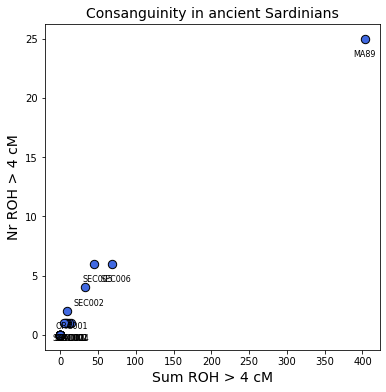

In [23]:
df1 = plot_sard_inbreed("./figures_test/roh_summary_ancsards.pdf")

In [24]:
df1

,iid,max_roh,sum_roh,n_roh
50,MA89,40.350711,402.742118,25
18,SEC006,29.807103,68.048221,6
20,SEC005,14.390397,45.006781,6
17,SEC002,16.036206,33.048906,4
51,ISC001,14.704597,14.704597,1
26,SUC004,11.566794,11.566794,1
43,ORC001,5.070700,9.350099,2
21,ORC002,9.098596,9.098596,1
52,SEC001,7.150597,7.150597,1
48,LON001,6.633401,6.633401,1


# Plot ROH against age

# Area 51

In [6]:
df1 = create_ancsard_df()
meta_df = pd.read_csv(meta_path)  # Load the Meta File

Saved to: ../../Empirical/AncSards/roh_summary.csv


In [7]:
meta_df

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp,full_iid
0,ORC008,Ancsard-2,39.667222,9.426111,-0.001334,NaN,3045.0,Marcus et al. 2018,Sar,Nur,1.0,Sar-Nur,1.754811,1.0,793519.0,ORC008.A0101.TF1.1
1,SUC005,Ancsard-2,40.810297,8.444178,0.005775,NaN,4161.0,Marcus et al. 2018,Sar,BA,1.0,Sar-EMBA,1.608429,1.0,764383.0,SUC005.A0101.TF1.1
2,MA86,Nuragic,39.870000,9.235600,NaN,NaN,3647.0,Marcus et al. 2018,Sar,Nur,0.0,Sar--9,0.127313,0.0,113856.0,MA86
3,SEC004,Ancsard-2,40.786192,8.595815,NaN,NaN,4333.0,Marcus et al. 2018,Sar,BA,1.0,Sar-EMBA,1.268179,1.0,608151.0,SEC004.A0101.TF1.1
4,SUA003,NaN,39.870000,9.235600,0.025000,0.01,3106.5,Marcus et al. 2018,Sar,?,1.0,Sar-Nur,0.220005,0.0,182986.0,SUA003
5,MA108,Bell Beakker,39.518600,8.875700,NaN,NaN,4336.5,Marcus et al. 2018,Sar,Bk,0.0,Sar--9,0.017021,0.0,17303.0,MA108
6,S1252,Ancsard_Haak,39.868827,9.235374,-0.500000,0.01,3650.0,Marcus et al. 2018,Sar,BA,1.0,Sar-EMBA,0.524666,0.0,382232.0,S1252
7,S1253,Ancsard_Haak,39.868827,9.235374,0.000000,0.01,3650.0,Marcus et al. 2018,Sar,BA,1.0,Sar-EMBA,0.039653,0.0,33628.0,S1253
8,MA104,Early Bronze Age,39.671900,8.820500,NaN,NaN,4469.0,Marcus et al. 2018,Sar,EBA,0.0,Sar--9,0.011460,0.0,11378.0,MA104
9,MA77,Neolithic,40.652600,8.610600,NaN,NaN,5569.0,Marcus et al. 2018,Sar,Neolithic,0.0,Sar--9,0.000758,0.0,846.0,MA77


In [12]:
def plot_age_roh(savepath = "../../Empirical/AncSards/roh_summary_age.pdf", save=False, ylim=[]):
    """Plot ROH against Age"""
    fsl = 18
    
    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    full_df = pd.merge(df1, meta_df[["iid","n_cov_snp", "age"]], on="iid", how="left")
    x, y = full_df["age"]-1950, full_df["sum_roh"]

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, c="royalblue", s=70, edgecolors="k")
    plt.xlabel("Age BCE [years]", fontsize=fsl)
    #plt.xlabel("SNPs covered", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM [cM]", fontsize=fsl)
    plt.gca().invert_xaxis()
    #plt.title("Consanguinity in ancient Sardinians", fontsize=fsl)

    #for i, txt in enumerate(full_df["iid"]):
    #    plt.annotate(txt, (x[i], y[i]))

    if len(ylim)>0:
        plt.ylim(ylim)
        
    if save==True:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()

Saved to ../../Empirical/AncSards/roh_summary_age.pdf


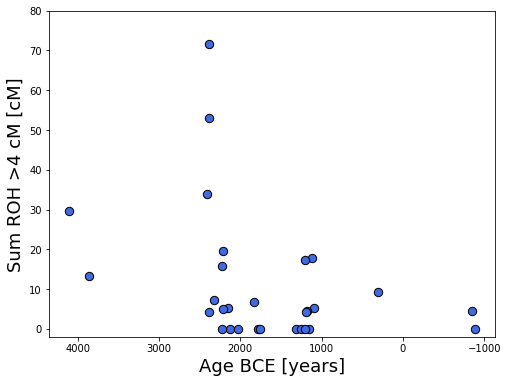

In [13]:
plot_age_roh(save=True, ylim=[-2,80])

In [10]:
### Do a single individual
df = load_rohs(iid="MA89")
df = post_process_roh_df(df, min_cm=3, snp_cm=100, output=True)
individual_roh_statistic(df, output=True)

Min SNPs per cM> 100: 96/101
> 3 cM: 31/96
Max. ROH: 40.237
Sum. ROH: 394.451
Nr. ROH: 31


(0.4023729600000001, 3.9445078799999997, 31)

In [9]:
df

,Start,End,StartM,EndM,length,lengthM,iid,ch
0,1704,1958,0.136153,0.154519,254,0.018366,MA89,1
1,3842,4040,0.249939,0.262297,198,0.012358,MA89,1
2,12219,12393,0.634141,0.646777,174,0.012636,MA89,1
3,15352,16207,0.742508,0.765589,855,0.023081,MA89,1
4,17302,17696,0.797746,0.815102,394,0.017356,MA89,1
5,53961,54414,2.182749,2.199856,453,0.017107,MA89,1
6,65788,66110,2.633378,2.647320,322,0.013942,MA89,1
0,2764,2933,0.181400,0.191581,169,0.010181,MA89,2
1,4135,6576,0.264470,0.385941,2441,0.121471,MA89,2
2,6583,8029,0.387579,0.430540,1446,0.042961,MA89,2
